In [65]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import autocorrelation_plot
from   statsmodels.tsa.arima_model import ARIMA
import tensorflow as tf
from   tensorflow import keras

%matplotlib inline

In [2]:
def plot_series(time, series, frmt='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], frmt, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend()
    plt.grid(True)

### Trend and Seasonality

In [3]:
def trend(time, slope=0):
    return slope * time

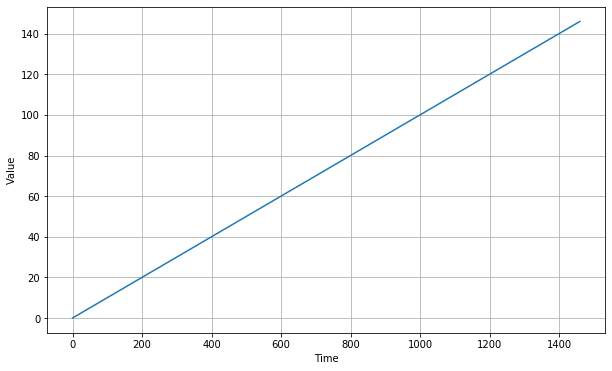

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
def seasonal_pattern(season_time):
    '''An arbitrary pattern'''
    return np.where(season_time < 0.4, 
                    np.cos(2 * np.pi * season_time),
                    1 / np.exp(3 * season_time))

In [6]:
def seasonality(time, period, amplitude=1, phase=0):
    '''Repeat pattern at each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

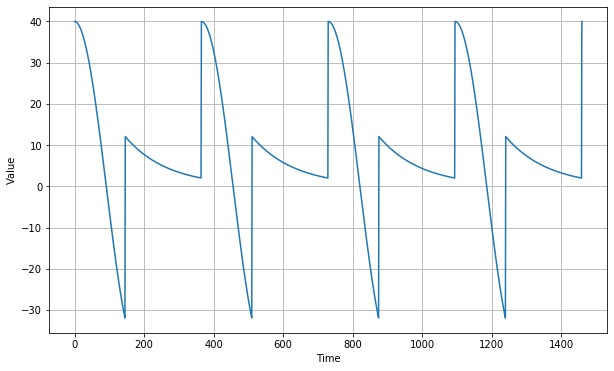

In [7]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)

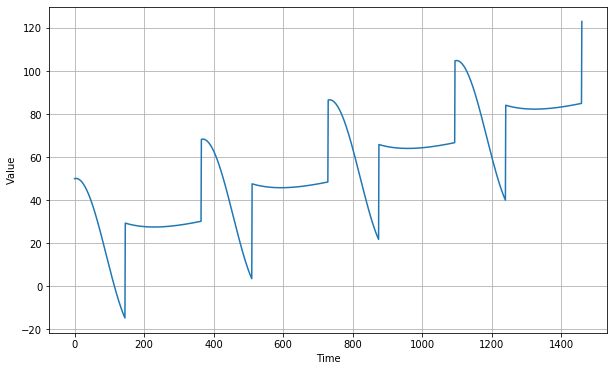

In [8]:
slope = 0.05
series = (baseline 
          + trend(time, slope) 
          + seasonality(time, period=365, amplitude=amplitude))

plt.figure(figsize=(10, 6))
plot_series(time, series)

### Noise

In [9]:
def white_noise(time, noise_level=1, seed=None):
    seed = seed or int(datetime.now().timestamp())
    rnd = np.random.RandomState(seed)
    return noise_level * rnd.randn(len(time))

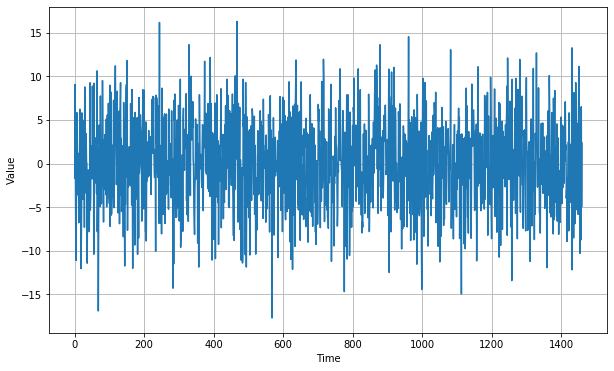

In [10]:
noise_level = 5
noise = white_noise(time, noise_level)

plt.figure(figsize=(10, 6))
plot_series(time, noise)

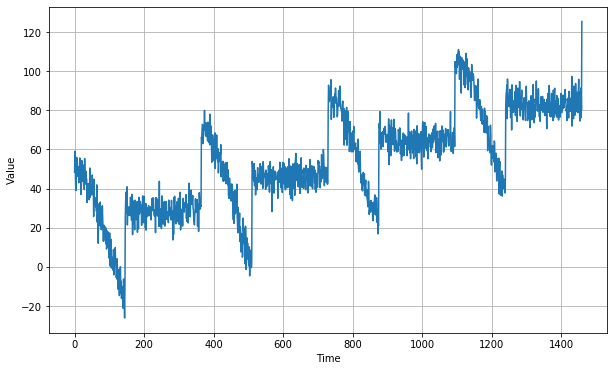

In [11]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
def autocorrelate(time, amplitude, order=1, seed=None):
    seed = seed or int(datetime.now().timestamp())
    rnd = np.random.RandomState(seed)
    if order == 1:
        φ1 = 0.8
        ar = rnd.randn(len(time) + 1)
        for step in range(1, len(time) + 1):
            ar[step] += φ1 * ar[step - 1]
        return ar[1:] * amplitude
    else:
        φ1 = 0.5
        φ2 = -0.1
        ar = rnd.randn(len(time) + 50)
        ar[:50] = 100
        for step in range(50, len(time) + 50):
            ar[step] += φ1 * ar[step - 50]
            ar[step] += φ2 * ar[step - 33]
        return ar[50:] * amplitude

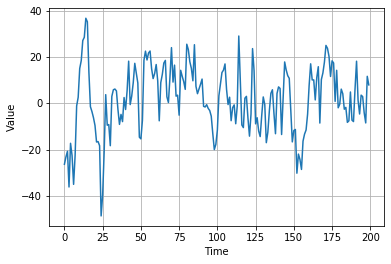

In [20]:
series = autocorrelate(time, 10)
plot_series(time[:200], series[:200])

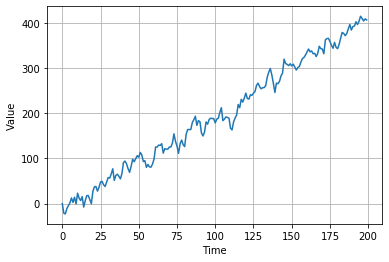

In [22]:
series = autocorrelate(time, 10) + trend(time, 2)
plot_series(time[:200], series[:200])

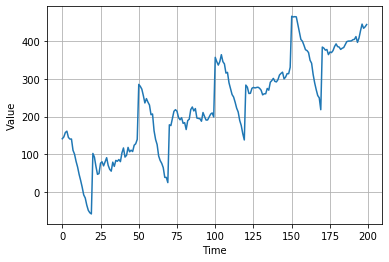

In [25]:
series = (autocorrelate(time, 10) 
          + seasonality(time, period=50, amplitude=150) 
          + trend(time, 2))
plot_series(time[:200], series[:200])

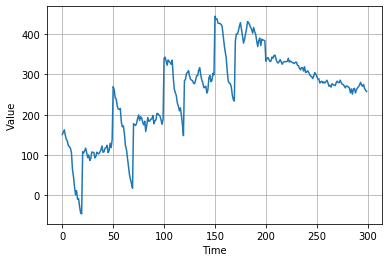

In [28]:
series = (autocorrelate(time, 10) 
          + seasonality(time, period=50, amplitude=150) 
          + trend(time, 2))
series2 = (autocorrelate(time, 5) 
           + seasonality(time, period=50, amplitude=2) 
           + trend(time, -1) 
           + 550)
series[200:] = series2[200:]
plot_series(time[:300], series[:300])

In [44]:
def impulse(time, n_impulses, amp=1, seed=None):
    seed = seed or int(datetime.now().timestamp())
    rnd = np.random.RandomState(seed)
    impulse_i = rnd.randint(len(time), size=n_impulses)
    series = np.zeros(len(time))
    for i in impulse_i:
        series[i] += rnd.rand() * amplitude
    return series

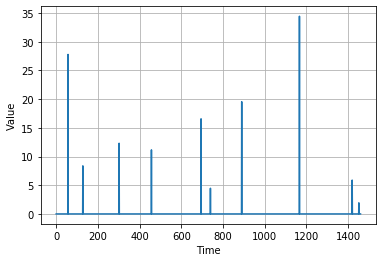

In [45]:
series = impulse(time, 10)
plot_series(time, series)

In [46]:
def autocorrelation(source, phis):
    ar = source.copy()
    max_lag = len(phis)
    for step, val in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
                ar[step] += phi * ar[step - lag]
    return ar

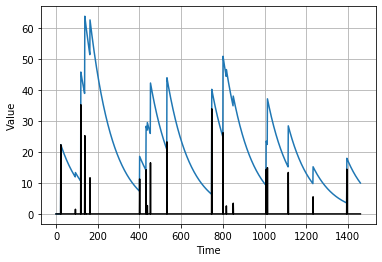

In [47]:
signal = impulse(time, 20)
series = autocorrelation(signal, {1: 0.99, 2: 0.001})
plot_series(time, series)
plt.plot(time, signal, 'k-');

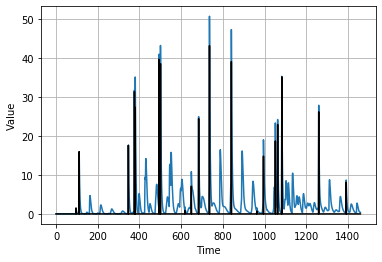

In [51]:
signal = impulse(time, 20)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, 'k-');

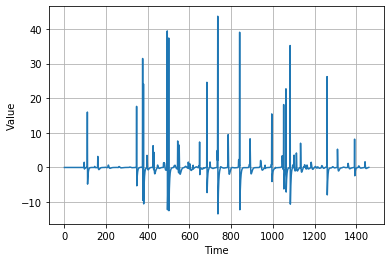

In [52]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

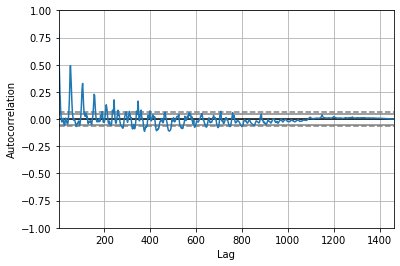

In [54]:
autocorrelation_plot(series);

In [58]:
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3760.462
Method:                       css-mle   S.D. of innovations              3.179
Date:                Thu, 24 Oct 2019   AIC                           7534.924
Time:                        08:29:27   BIC                           7571.927
Sample:                             1   HQIC                          7548.728
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.053      0.005      0.996      -0.105       0.105
ar.L1.D.y     -0.1497      0.026     -5.748      0.000      -0.201      -0.099
ar.L2.D.y     -0.1335      0.026     -5.076      0.000      -0.185      -0.082
ar.L3.D.y     -0.1310      0.026     -4.982      0.000      -0.183      -0.079
ar.L4.D.y     -0.0483      0.026     -1.837      0.066      -0.100       0.003
ar.L5.D.y     -0.0938      0.026     -3.606      0.000      -0.145      -0.043
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0482           -1.1540j            1.5590           -0.1326
AR.2            1.0482           +1.1540j            1.5590            0.1326
AR.3           -1.5649           -0.0000j            1.5649           -0.5000
AR.4           -0.5232           -1.5905j            1.6743           -0.3006
AR.5           -0.5232           +1.5905j            1.6743            0.3006
-----------------------------------------------------------------------------
"""

In [67]:
DATA = '../../../data'
df = pd.read_csv(
    f'{DATA}/sunspots.csv', parse_dates=True)
df.head()

,Unnamed: 0,time,value
0,1,1749.000000,58.0
1,2,1749.083333,62.6
2,3,1749.166667,70.0
3,4,1749.250000,55.7
4,5,1749.333333,85.0


In [68]:
df.tail()

,Unnamed: 0,time,value
2815,2816,1983.583333,71.8
2816,2817,1983.666667,50.3
2817,2818,1983.750000,55.8
2818,2819,1983.833333,33.3
2819,2820,1983.916667,33.4
